## Challenge Set 1
**Topic**:        Explore MTA turnstile data

**Date**:         07/11/2016

**Name**:         Emily Robinson


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
from datetime import datetime
import seaborn as sns
from collections import defaultdict

%matplotlib inline

//anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


**Challenge 1** 

Download 4 weeks of MTA turnstile data, open and use a csv reader to read it. 
Create a list of four dictionaries, one for each week 

In [9]:
!curl -O http://web.mta.info/developers/data/nyct/turnstile/turnstile_150627.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.0M    0 24.0M    0     0   297k      0 --:--:--  0:01:22 --:--:--  324k


In [36]:
!curl -O http://web.mta.info/developers/data/nyct/turnstile/turnstile_150620.txt
!curl -O http://web.mta.info/developers/data/nyct/turnstile/turnstile_150606.txt
!curl -O http://web.mta.info/developers/data/nyct/turnstile/turnstile_150613.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.1M    0 24.1M    0     0   569k      0 --:--:--  0:00:43 --:--:--  529k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23.9M    0 23.9M    0     0   552k      0 --:--:--  0:00:44 --:--:--  559k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23.8M    0 23.8M    0     0   513k      0 --:--:--  0:00:47 --:--:--  582k


In [3]:
def create_dict(list_of_files):
    all_raw_readings = []
    for MTA_file in list_of_files: 
        with open(MTA_file) as f:
            reader = csv.reader(f)
            rows = [[cell.strip() for cell in row] for row in reader]
        assert rows.pop(0) == ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME',
                       'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES',
                       'EXITS']
        raw_readings = {}    
        for row in rows:
            raw_readings.setdefault(tuple(row[:4]), []).append(tuple(row[4:]))
        all_raw_readings.append(raw_readings)
    return(all_raw_readings)

In [4]:
list_of_MTA_files = ['turnstile_150613.txt', 'turnstile_150606.txt', 'turnstile_150620.txt', 'turnstile_150627.txt'] 
MTA_dictionaries = create_dict(list_of_MTA_files)

In [5]:
# Combine dictionaries
raw_readings = defaultdict(list)

for d in (MTA_dictionaries): 
    for key, value in d.iteritems():
        raw_readings[key].append(value)     
# but now values have values within them 
#[item for sublist in values for item in sublist]
new_dict = {k: np.array(v).flatten() for k, v in raw_readings.items()}

raw_readings is the solution to Challenge 1

**Challenge 2** 

Turn raw_readings into a time series

In [6]:
datetime_cumulative = {turnstile: [(datetime.strptime(date + time,
                                                      '%m/%d/%Y%X'),
                                    int(in_cumulative))
                                   for _, _, date, time,
                                       _, in_cumulative, _ in rows]
                       for turnstile, rows in new_dict.items()}

ValueError: too many values to unpack

In [29]:
datetime_cumulative_new = defaultdict(lambda: [])

for turnstile, rows in raw_readings.items():
    for value in rows: 
        datetime_cumulative_new[turnstile].append([(datetime.strptime(date + time,'%m/%d/%Y%X'),int(in_cumulative))
                                   for _, _, date, time,
                                       _, in_cumulative, _ in value])
        
    

In [65]:

datetime_cumulative_new1 = defaultdict(lambda: [])

# flatten dictionary 
for turnstile, rows in datetime_cumulative_new.items():
    flattened  = [val for sublist in rows for val in sublist]
    # turn values back into tuples
    datetime_cumulative_new1[turnstile] = sorted(flattened)


In [66]:
# Create dictionary with value as a list of datetimes and the entires
datetime_count_times = {turnstile: [[rows[i][0],
                                     rows[i+1][1] - rows[i][1]]
                                    for i in range(len(rows) - 1)]
                        for turnstile, rows in datetime_cumulative_new1.items()}

datetime_count_times is the answer

**Challenge 3** 

Create dictionary with same keys but value now list of day-entry total pairs

In [67]:
day_counts = {}
for turnstile, rows in datetime_count_times.items():
    by_day = {}
    for time, count in rows:
        day = time.date()
        by_day[day] = by_day.get(day, 0) + count
    day_counts[turnstile] = sorted(by_day.items())

day_counts if the answer

**Challenge 4** 

Plot daily time series for a turnstile. Turn the value list into two lists, date and counts

In [69]:
# Pick random turnstile for graph
turnstile1 = day_counts.items()[8]
# turnstile1 is tuple, 2nd one is list of datetime and count
dates = []
counts = []
for i, j in turnstile1[1]:
    dates.append(i)
    counts.append(j)
    

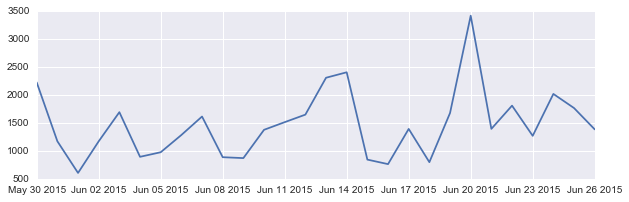

In [70]:
plt.figure(figsize=(10,3))
plt.plot(dates,counts)

**Challenge 5** 

For each ControlArea/UNIT/STATION combo, for each day, add the counts from each turnstile belonging to that combo.

In [71]:
combo_counts = {}
for turnstile, date_counts in day_counts.items():
    by_day = {}
    combo = (turnstile[0], turnstile[1], turnstile[3])
    combo_counts[combo] = date_counts

combo_counts is the answer

**Challenge 6** 

Combine everything in each station

In [73]:
station_counts = {}
for combo, date_counts in combo_counts.items():
    by_day = {}
    # get the station for this combo
    station = combo[2]
    # if the station is already in our new dictionary, add our entries in 
    if station in station_counts: 
        # initialize by_day dictionary with current day totals for that station
        for date, count in station_counts[station]:
            by_day[date] = by_day.get(day, 0) + count
        # add in this new combo counts to the station count
        for d, c in date_counts:
            by_day[d] = by_day.get(day, 0) + c
        # change entry to updated count
        combo_counts[station] = sorted(by_day.items())
    # if station isn't in dictionary yet, make an entry for the station with this turnstile's values
    else: 
        station_counts[station] = date_counts

station_counts is the answer

**Challenge 7** 

Plot the time series for a station

In [77]:
# Pick random turnstile for graph
station = station_counts.items()[10]
# turnstile1 is tuple, 2nd one is list of datetime and count
dates = []
counts = []
for i, j in station[1]:
    dates.append(i)
    counts.append(j)

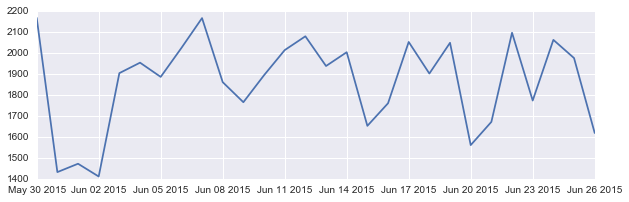

In [76]:
plt.figure(figsize=(10,3))
plt.plot(dates,counts)

**Challenge 8** 

Make one list of counts for one week for one station. Monday's count, Tuesday's count, etc. so it's a list of 7 counts. Make the same list for another week, and another week, and another week. plt.plot(week_count_list) for every week_count_list you created this way. You should get a rainbow plot of weekly commute numbers on top of each other.

In [99]:
# Use same station as for challenge 7
station
# it always starts on a saturday
# get a list of counts
counts = [count[1] for count in station[1]]
# make list of lists for each week
chunks = [counts[x:x+7] for x in xrange(0, len(counts), 7)]
print chunks

[[2169, 1432, 1472, 1411, 1905, 1955, 1887], [2025, 2168, 1862, 1766, 1895, 2015, 2081], [1939, 2005, 1653, 1761, 2054, 1903, 2050], [1561, 1672, 2098, 1774, 2064, 1977, 1619]]


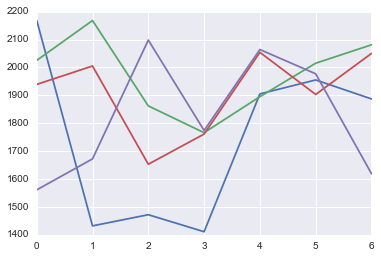

In [131]:
for chunk in chunks:
    plt.plot(chunk)

**Challenge 9**

Over multiple weeks, sum total ridership for each station and sort them, so you can find out the stations with the highest traffic during the time you investigate

In [115]:
total_ridership = defaultdict(lambda x: 0)
for turnstile, date_counts in station_counts.items(): 
    tr = 0
    for dc in date_counts: 
        tr += dc[1]
    total_ridership[turnstile] = tr

('HIGH ST', 52173)


total_ridership is the answer

**Challenge 10**

Create histogram of total ridership

(array([ 100.,  102.,   71.,   53.,   26.,    8.,    2.,    2.,    0.,    1.]),
 array([  2.00000000e+00,   1.51662000e+04,   3.03304000e+04,
          4.54946000e+04,   6.06588000e+04,   7.58230000e+04,
          9.09872000e+04,   1.06151400e+05,   1.21315600e+05,
          1.36479800e+05,   1.51644000e+05]),
 <a list of 10 Patch objects>)

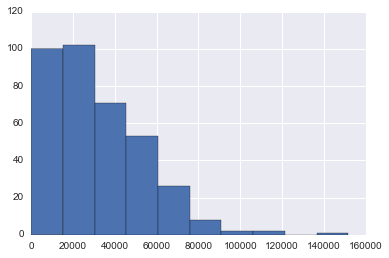

In [133]:
total_ridership_counts = total_ridership.values()
# take out any total_ridership negatives or zeros
total_ridership_values = [count for count in total_ridership_counts if count > 0]
plt.hist(total_ridership_values)